<a href="https://colab.research.google.com/github/christophergaughan/GNN-Antibiotics/blob/main/GNN_Generation_of_new_antibiotics__simple_starteripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Pipeline introduction to working with ChEMBL and GNN

## ChEMBL Antibiotics Data Analysis with Enhanced Binding Features

## Introduction

In this notebook, we aim to retrieve, analyze, and manipulate data related to **antibiotics** from the **ChEMBL** database. The goal is to identify compounds with **enhanced binding properties** by focusing on compounds that show a strong inhibitory effect, specifically targeting those with **IC50 values ≤ 1000 nM**. An **IC50 value** represents the concentration of a substance needed to inhibit a biological process by 50%, with lower values indicating **stronger binding affinity**.

## Objectives

1. **Data Retrieval**:
   - Connect to the ChEMBL database and query for compounds related to **antibacterial activity**.
   - Filter data to focus on **IC50 values** and retrieve key information like **canonical SMILES**, **assay descriptions**, and **activity comments**.

2. **Data Cleaning and Preprocessing**:
   - **Remove Duplicates**: Identify and remove duplicate records to ensure data integrity.
   - **Handle Missing Values**: Inspect the dataset for **NaN (Not a Number)** values and handle them appropriately by either filling or removing them.
   - **Convert Data Types**: Ensure that crucial columns like **IC50 values** are in the correct numeric format for analysis.

3. **Labeling Active Compounds**:
   - Create a binary classification for each compound:
     - **Active**: Compounds with IC50 values **≤ 1000 nM**, indicating strong binding and potential as effective antibiotics.
     - **Inactive**: Compounds with IC50 values **> 1000 nM**.

4. **Molecular Descriptors Calculation**:
   - Using **RDKit**, calculate molecular descriptors such as **hydrogen bond donors**, **hydrogen bond acceptors**, **molecular weight**, **number of rings**, **topological polar surface area (TPSA)**, and **rotatable bonds**.
   - Generate **Morgan fingerprints** for each molecule to capture **structural features**.

5. **TF-IDF Feature Extraction**:
   - Convert textual information from **assay descriptions** and **activity comments** into numerical features using **TF-IDF (Term Frequency-Inverse Document Frequency)**.
   - Enrich the dataset with these features for potential machine learning tasks.

## Motivation

Antibiotics with **enhanced binding features** are crucial in the fight against **antimicrobial resistance**. By focusing on compounds that demonstrate strong inhibitory effects, we aim to identify promising candidates for further study and development. The insights gained from this analysis can potentially guide **drug discovery efforts** and highlight key structural features that contribute to the **potency** of antibiotics.

## Prerequisites

This notebook is designed to be run on **Google Colab** with **GPU (A100)** support for faster computation. We will make use of the following Python libraries:
- **pandas, numpy**: For data manipulation and analysis.
- **torch, torch-geometric**: For potential deep learning tasks involving **graph-based neural networks**.
- **chembl-webresource-client**: To query the ChEMBL database.
- **rdkit**: To calculate molecular descriptors and fingerprints.
- **scikit-learn**: For feature extraction and machine learning preprocessing.
- **matplotlib, seaborn**: For data visualization.

## Expected Outcome

By the end of this notebook, we will have a **cleaned, enriched, and labeled dataset** of antibiotics compounds, ready for downstream analysis. This dataset can be used for:
- **Machine Learning** models to predict the binding affinity of new compounds.
- **Exploratory Data Analysis (EDA)** to understand key structural features contributing to antibacterial activity.
- **Visualizations** that illustrate the distribution of **IC50 values**, molecular properties, and other features.

Let's dive in and start analyzing the data to uncover potential candidates for **highly effective antibiotics** with **enhanced binding characteristics**!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Cell 1: Setup and imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors

# Verify GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("GPU not available, using CPU")

Using GPU: NVIDIA A100-SXM4-80GB


In [6]:
# Cell 2: Paginated ChEMBL query
from chembl_webresource_client.new_client import new_client

chembl = new_client.activity

# Paginate to avoid server memory issues
all_activities = []
offset = 0
limit = 1000  # Fetch 1000 at a time

print("Fetching data from ChEMBL (paginated)...")

while True:
    print(f"  Fetching records {offset} to {offset + limit}...")

    batch = chembl.filter(
        target_chembl_id='CHEMBL240',
        standard_type='IC50'
    ).only(
        'molecule_chembl_id',
        'canonical_smiles',
        'standard_value'
    )[offset:offset + limit]

    batch_list = list(batch)

    if not batch_list:
        break

    all_activities.extend(batch_list)
    offset += limit

    # Safety cap - don't fetch more than 10K for now
    if offset >= 10000:
        print("  Reached 10K cap, stopping.")
        break

print(f"\nTotal records retrieved: {len(all_activities)}")

# Convert to DataFrame
data = pd.DataFrame(all_activities)
data.head()

Fetching data from ChEMBL (paginated)...
  Fetching records 0 to 1000...
  Fetching records 1000 to 2000...
  Fetching records 2000 to 3000...
  Fetching records 3000 to 4000...
  Fetching records 4000 to 5000...
  Fetching records 5000 to 6000...
  Fetching records 6000 to 7000...
  Fetching records 7000 to 8000...
  Fetching records 8000 to 9000...
  Fetching records 9000 to 10000...
  Reached 10K cap, stopping.

Total records retrieved: 1180


,canonical_smiles,molecule_chembl_id,standard_value,value
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,14.0,14.0
1,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,3.0,3.0
2,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,32.2,32.2
3,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,5950.0,5950.0
4,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,143.0,143.0


In [7]:
# Cell 3: Clean and label
filtered_data = data[['molecule_chembl_id', 'canonical_smiles', 'standard_value']].dropna()
filtered_data['standard_value'] = pd.to_numeric(filtered_data['standard_value'], errors='coerce')
filtered_data = filtered_data.dropna()

# Binary label: active if IC50 <= 1000 nM
filtered_data['active'] = (filtered_data['standard_value'] <= 1000).astype(int)

# Remove duplicate SMILES (keep lowest IC50)
filtered_data = filtered_data.sort_values('standard_value').drop_duplicates(subset='canonical_smiles', keep='first')

print(f"Cleaned dataset: {len(filtered_data)} unique compounds")
print(f"Active (IC50 ≤ 1000 nM): {filtered_data['active'].sum()}")
print(f"Inactive: {(filtered_data['active'] == 0).sum()}")

Cleaned dataset: 915 unique compounds
Active (IC50 ≤ 1000 nM): 227
Inactive: 688


In [8]:
# Cell 4: Convert SMILES to PyTorch Geometric graphs
from torch_geometric.data import Data
import torch

def mol_to_graph(smiles, label):
    """Convert SMILES to PyTorch Geometric Data object"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features: atomic number, degree, formal charge, hybridization, aromaticity
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic()),
            atom.GetTotalNumHs(),
        ]
        atom_features.append(features)

    x = torch.tensor(atom_features, dtype=torch.float)

    # Edge index from bonds
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])  # Undirected

    if len(edge_index) == 0:
        # Single atom molecule - add self-loop
        edge_index = [[0, 0]]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y)

# Convert all molecules
print("Converting SMILES to graphs...")
graph_data = []
failed = 0

for idx, row in filtered_data.iterrows():
    graph = mol_to_graph(row['canonical_smiles'], row['active'])
    if graph is not None:
        graph_data.append(graph)
    else:
        failed += 1

print(f"Successfully converted: {len(graph_data)} molecules")
print(f"Failed conversions: {failed}")
print(f"\nSample graph: {graph_data[0]}")

Converting SMILES to graphs...
Successfully converted: 915 molecules
Failed conversions: 0

Sample graph: Data(x=[34, 6], edge_index=[2, 76], y=[1])


In [9]:
# Cell 5: Train/Val/Test split and DataLoaders
from torch_geometric.loader import DataLoader
import random

# Shuffle
random.seed(42)
random.shuffle(graph_data)

# 80/10/10 split
n = len(graph_data)
train_data = graph_data[:int(0.8*n)]
val_data = graph_data[int(0.8*n):int(0.9*n)]
test_data = graph_data[int(0.9*n):]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Count labels in each split
train_pos = sum(1 for g in train_data if g.y.item() == 1)
val_pos = sum(1 for g in val_data if g.y.item() == 1)
test_pos = sum(1 for g in test_data if g.y.item() == 1)
print(f"Train active: {train_pos}/{len(train_data)}")
print(f"Val active: {val_pos}/{len(val_data)}")
print(f"Test active: {test_pos}/{len(test_data)}")

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Train: 732, Val: 91, Test: 92
Train active: 180/732
Val active: 19/91
Test active: 28/92


In [12]:
# Cell 6: Define GNN Model
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class AntibioticGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
        super(AntibioticGCN, self).__init__()

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)

        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = torch.nn.Linear(hidden_dim // 2, 1)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        # Pool to graph-level
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Initialize
model = AntibioticGCN(input_dim=6, hidden_dim=64, dropout=0.2).to(device)
print(model)
print(f"\nParameters: {sum(p.numel() for p in model.parameters()):,}")

AntibioticGCN(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Parameters: 11,265


In [13]:
# Cell 7: Training loop
from sklearn.metrics import roc_auc_score, accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch).squeeze()
        loss = criterion(out, batch.y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        out = torch.sigmoid(model(batch).squeeze())
        preds.extend(out.cpu().numpy())
        labels.extend(batch.y.squeeze().cpu().numpy())
    auc = roc_auc_score(labels, preds)
    acc = accuracy_score(labels, [1 if p > 0.5 else 0 for p in preds])
    return auc, acc, preds, labels

# Train
print("Training...")
print("-" * 50)
best_val_auc = 0
train_losses, val_aucs = [], []

for epoch in range(1, 101):
    loss = train_epoch(model, train_loader)
    val_auc, val_acc, _, _ = evaluate(model, val_loader)

    train_losses.append(loss)
    val_aucs.append(val_auc)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_antibiotic_gcn.pt')

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f}")

print("-" * 50)
print(f"Best Val AUC: {best_val_auc:.4f}")

Training...
--------------------------------------------------
Epoch  10 | Loss: 0.4868 | Val AUC: 0.6418 | Val Acc: 0.8022
Epoch  20 | Loss: 0.4557 | Val AUC: 0.7178 | Val Acc: 0.8132
Epoch  30 | Loss: 0.4367 | Val AUC: 0.7456 | Val Acc: 0.8022
Epoch  40 | Loss: 0.4218 | Val AUC: 0.7705 | Val Acc: 0.7802
Epoch  50 | Loss: 0.4047 | Val AUC: 0.7851 | Val Acc: 0.7912
Epoch  60 | Loss: 0.3967 | Val AUC: 0.7931 | Val Acc: 0.7802
Epoch  70 | Loss: 0.3955 | Val AUC: 0.7858 | Val Acc: 0.7802
Epoch  80 | Loss: 0.3927 | Val AUC: 0.7887 | Val Acc: 0.8022
Epoch  90 | Loss: 0.3687 | Val AUC: 0.7924 | Val Acc: 0.8022
Epoch 100 | Loss: 0.3690 | Val AUC: 0.8077 | Val Acc: 0.8022
--------------------------------------------------
Best Val AUC: 0.8085


In [14]:
# Cell 8: Final Test Evaluation
model.load_state_dict(torch.load('best_antibiotic_gcn.pt'))
test_auc, test_acc, test_preds, test_labels = evaluate(model, test_loader)

print("=" * 50)
print("FINAL TEST SET RESULTS")
print("=" * 50)
print(f"ROC-AUC:  {test_auc:.4f}")
print(f"Accuracy: {test_acc:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, [1 if p > 0.5 else 0 for p in test_preds])
print(f"\nConfusion Matrix:")
print(f"  TN: {cm[0,0]:3d}  FP: {cm[0,1]:3d}")
print(f"  FN: {cm[1,0]:3d}  TP: {cm[1,1]:3d}")

FINAL TEST SET RESULTS
ROC-AUC:  0.7478
Accuracy: 0.7609

Confusion Matrix:
  TN:  60  FP:   4
  FN:  18  TP:  10


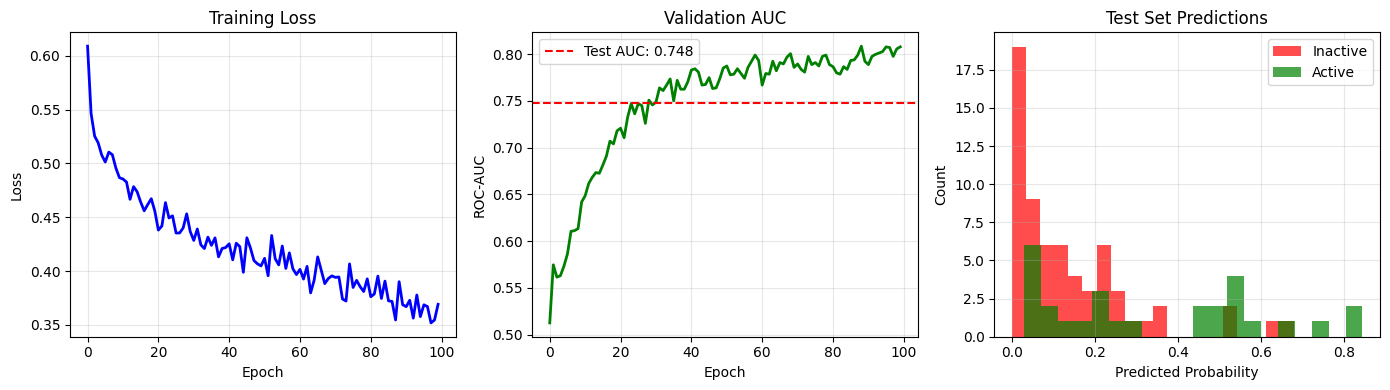


✓ Figure saved to antibiotic_gnn_results.png


In [15]:
# Cell 9: Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Loss curve
axes[0].plot(train_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Validation AUC
axes[1].plot(val_aucs, 'g-', linewidth=2)
axes[1].axhline(y=test_auc, color='r', linestyle='--', label=f'Test AUC: {test_auc:.3f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Validation AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Prediction distribution
axes[2].hist([p for p, l in zip(test_preds, test_labels) if l == 0],
             bins=20, alpha=0.7, label='Inactive', color='red')
axes[2].hist([p for p, l in zip(test_preds, test_labels) if l == 1],
             bins=20, alpha=0.7, label='Active', color='green')
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Predictions')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('antibiotic_gnn_results.png', dpi=150)
plt.show()

print("\n✓ Figure saved to antibiotic_gnn_results.png")

In [16]:
# Cell 10: Get top active compounds as starting points
top_actives = filtered_data[filtered_data['active'] == 1].nsmallest(10, 'standard_value')
print("Top 10 most potent compounds (lowest IC50):")
print(top_actives[['molecule_chembl_id', 'canonical_smiles', 'standard_value']].to_string())

Top 10 most potent compounds (lowest IC50):
    molecule_chembl_id                                                               canonical_smiles  standard_value
385       CHEMBL296419                             COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1           0.900
90         CHEMBL60796                              Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1           1.000
445       CHEMBL204828                     O=C(NC1CCN(Cc2ccc3c(c2)OCO3)CC1)c1cc(=O)c2cc(Cl)c(Cl)cc2o1           1.400
425       CHEMBL217706                         O=C(NC1CCN(Cc2ccc3c(c2)OCO3)CC1)c1cc(=O)c2ccc(Br)cc2o1           2.500
988       CHEMBL409224                       COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(Cl)cc1)CC2           2.512
1          CHEMBL12713                           O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1           3.000
593       CHEMBL227134  CS(=O)(=O)Nc1ccc(CCN(CCOc2ccc(NS(C)(=O)=O)cc2)c2ccc([N+](=O)[O-])c3nonc23)cc1           3.000
424       CH

Saved to: /content/drive/MyDrive/GNN_antibiotics/top10_active_structures.png


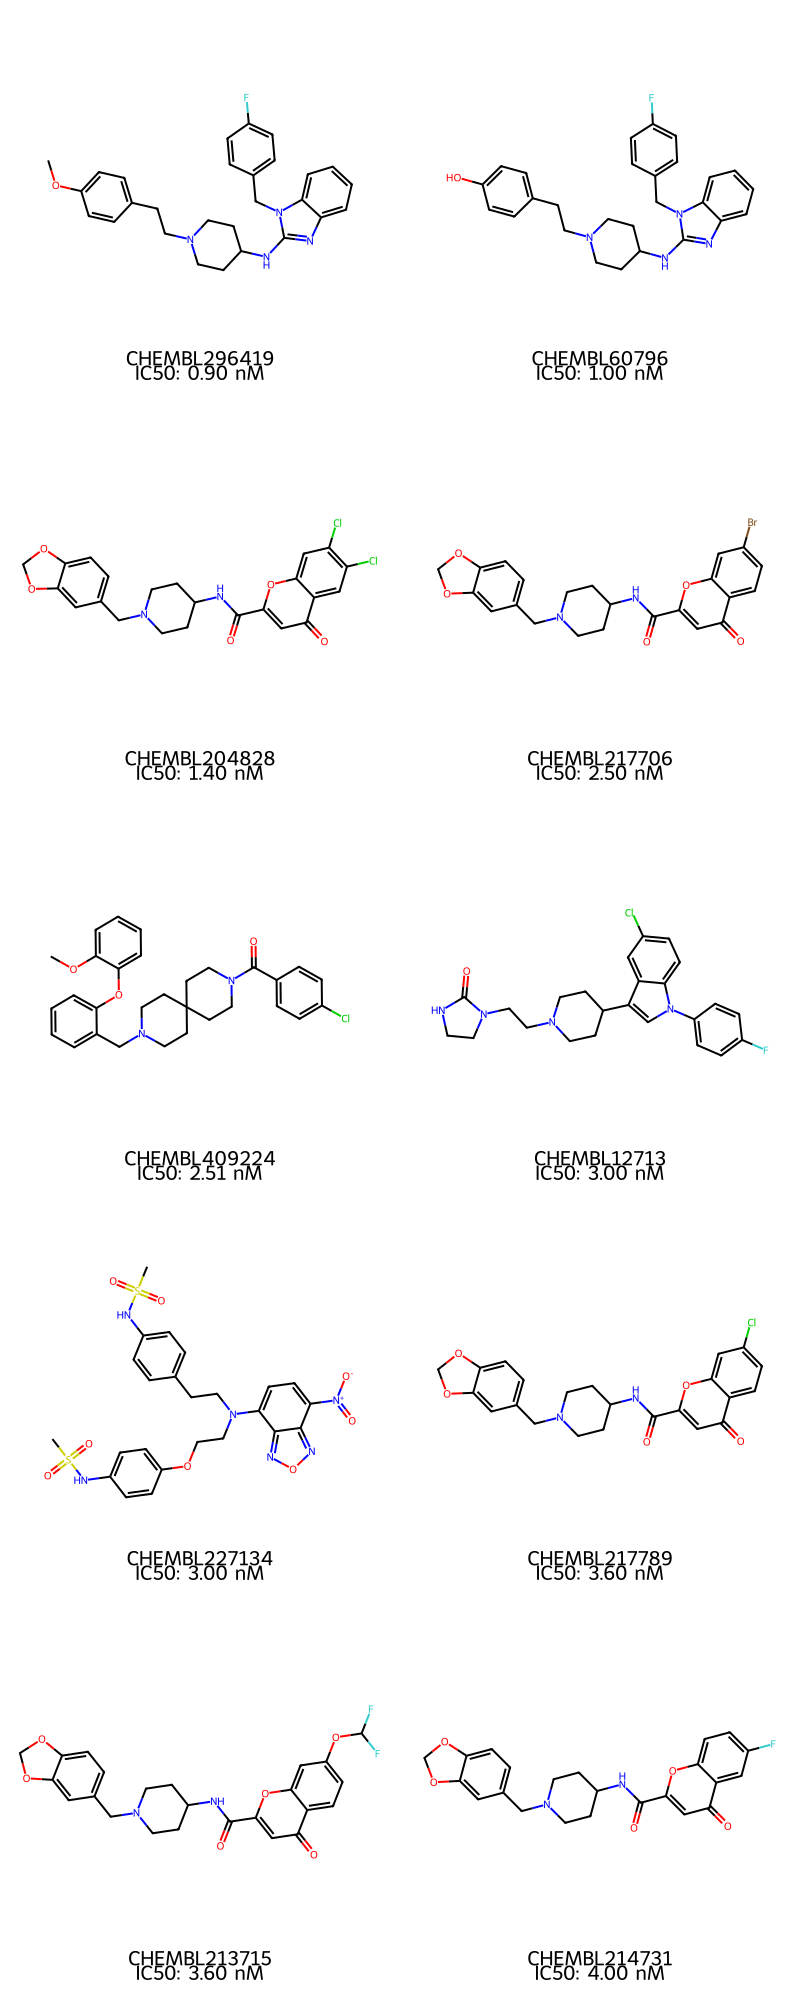

In [21]:
# Cell 10b: Visualize top 10 active compounds - direct approach
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.display import display
import PIL

mols = []
legends = []

for idx, row in top_actives.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol:
        mols.append(mol)
        legends.append(f"{row['molecule_chembl_id']}\nIC50: {row['standard_value']:.2f} nM")

# Force PIL return
from rdkit.Chem.Draw import rdMolDraw2D

def mol_grid_to_png(mols, legends, molsPerRow=2, subImgSize=(400,400)):
    nRows = (len(mols) + molsPerRow - 1) // molsPerRow
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])

    d2d = rdMolDraw2D.MolDraw2DCairo(fullSize[0], fullSize[1], subImgSize[0], subImgSize[1])
    d2d.drawOptions().legendFontSize = 20
    d2d.DrawMolecules(mols, legends=legends)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

png_data = mol_grid_to_png(mols, legends)

# Save directly
save_path = '/content/drive/MyDrive/GNN_antibiotics/top10_active_structures.png'
with open(save_path, 'wb') as f:
    f.write(png_data)
print(f"Saved to: {save_path}")

# Display
from IPython.display import Image
display(Image(png_data))

SVG saved to: /content/drive/MyDrive/GNN_antibiotics/top10_active_structures.svg


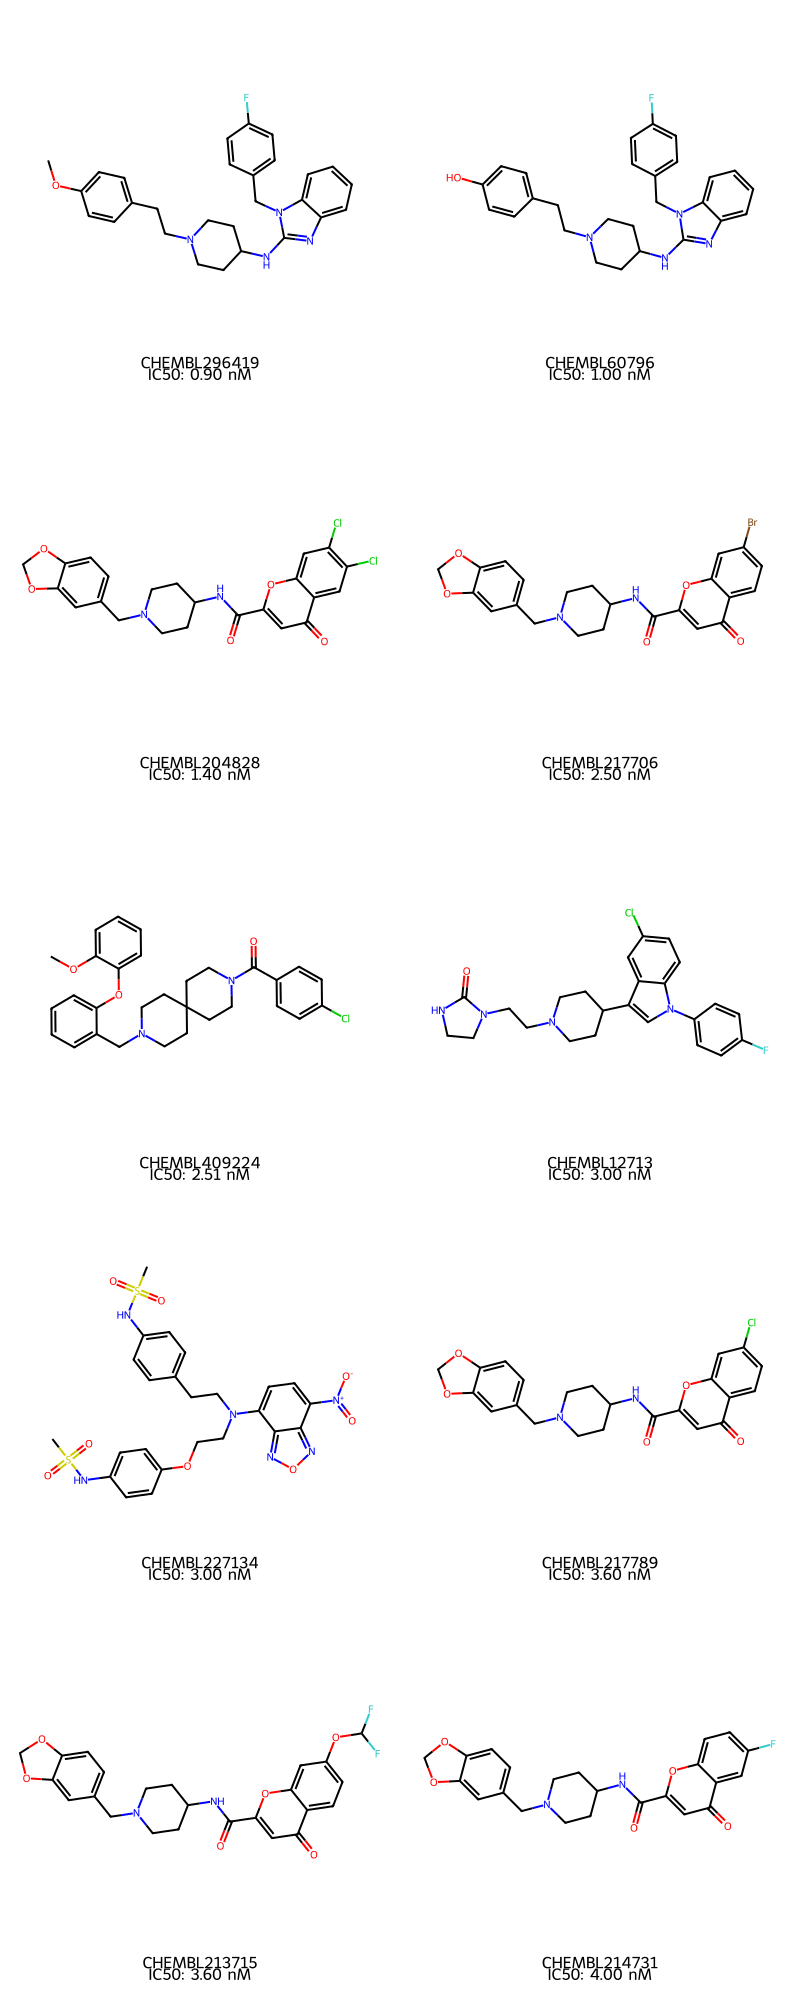

In [22]:
# Cell 10c: SVG version (optional - for publications/presentations)
from rdkit.Chem.Draw import rdMolDraw2D

# Create a larger SVG grid
n_cols = 2
n_rows = 5
img_size = 400

drawer = rdMolDraw2D.MolDraw2DSVG(img_size * n_cols, img_size * n_rows, img_size, img_size)
drawer.drawOptions().addStereoAnnotation = True
drawer.drawOptions().addAtomIndices = False

drawer.DrawMolecules(mols, legends=legends)
drawer.FinishDrawing()

svg = drawer.GetDrawingText()

# Save SVG
svg_path = '/content/drive/MyDrive/GNN_antibiotics/top10_active_structures.svg'
with open(svg_path, 'w') as f:
    f.write(svg)
print(f"SVG saved to: {svg_path}")

# Display in notebook
from IPython.display import SVG, display
display(SVG(svg))

In [23]:
# Cell 11: Molecular perturbation - generate novel candidates
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
import random

def mutate_molecule(mol, num_mutations=1):
    """Generate variants by small chemical modifications"""
    variants = []
    smiles = Chem.MolToSmiles(mol)

    # Strategy 1: Replace halogens (F, Cl, Br) with each other
    halogen_replacements = [('F', 'Cl'), ('Cl', 'F'), ('Cl', 'Br'), ('Br', 'Cl'), ('F', 'Br')]
    for old, new in halogen_replacements:
        if old in smiles:
            new_smiles = smiles.replace(old, new, 1)
            new_mol = Chem.MolFromSmiles(new_smiles)
            if new_mol:
                variants.append(Chem.MolToSmiles(new_mol))

    # Strategy 2: Add/remove methyl groups
    methyl_patterns = [
        ('c1ccccc1', 'c1ccc(C)cc1'),  # Add methyl to benzene
        ('CC', 'C'),  # Remove methyl
    ]
    for old, new in methyl_patterns:
        if old in smiles:
            new_smiles = smiles.replace(old, new, 1)
            new_mol = Chem.MolFromSmiles(new_smiles)
            if new_mol:
                variants.append(Chem.MolToSmiles(new_mol))

    # Strategy 3: Hydroxyl/Methoxy swap
    if 'OC' in smiles:
        new_smiles = smiles.replace('OC', 'O', 1)
        new_mol = Chem.MolFromSmiles(new_smiles)
        if new_mol:
            variants.append(Chem.MolToSmiles(new_mol))

    return list(set(variants))  # Remove duplicates

def check_drug_likeness(mol):
    """Lipinski's Rule of Five"""
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)

    violations = 0
    if mw > 500: violations += 1
    if logp > 5: violations += 1
    if hbd > 5: violations += 1
    if hba > 10: violations += 1

    return violations <= 1, {'MW': mw, 'LogP': logp, 'HBD': hbd, 'HBA': hba}

# Generate variants from top actives
print("Generating novel molecular variants...")
all_variants = []
training_smiles = set(filtered_data['canonical_smiles'].tolist())

for idx, row in top_actives.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol:
        variants = mutate_molecule(mol)
        for var_smiles in variants:
            # Check it's truly novel (not in training set)
            if var_smiles not in training_smiles:
                var_mol = Chem.MolFromSmiles(var_smiles)
                if var_mol:
                    is_druglike, props = check_drug_likeness(var_mol)
                    if is_druglike:
                        all_variants.append({
                            'smiles': var_smiles,
                            'parent_chembl_id': row['molecule_chembl_id'],
                            'parent_ic50': row['standard_value'],
                            **props
                        })

print(f"Generated {len(all_variants)} novel drug-like variants")

Generating novel molecular variants...
Generated 25 novel drug-like variants


In [24]:
# Cell 12: Score novel compounds with trained GNN
model.load_state_dict(torch.load('best_antibiotic_gcn.pt'))
model.eval()

scored_variants = []

for var in all_variants:
    graph = mol_to_graph(var['smiles'], label=0)  # Label doesn't matter for inference
    if graph:
        graph = graph.to(device)
        with torch.no_grad():
            # Need to create a batch
            from torch_geometric.data import Batch
            batch = Batch.from_data_list([graph])
            score = torch.sigmoid(model(batch)).item()

        var['predicted_activity'] = score
        scored_variants.append(var)

# Sort by predicted activity
scored_variants = sorted(scored_variants, key=lambda x: x['predicted_activity'], reverse=True)

print("\n" + "="*70)
print("TOP 10 NOVEL ANTIBIOTIC CANDIDATES")
print("="*70)

for i, var in enumerate(scored_variants[:10], 1):
    print(f"\n{i}. Predicted Activity: {var['predicted_activity']:.3f}")
    print(f"   SMILES: {var['smiles']}")
    print(f"   Parent: {var['parent_chembl_id']} (IC50: {var['parent_ic50']:.1f} nM)")
    print(f"   MW: {var['MW']:.1f}, LogP: {var['LogP']:.2f}, HBD: {var['HBD']}, HBA: {var['HBA']}")


TOP 10 NOVEL ANTIBIOTIC CANDIDATES

1. Predicted Activity: 0.865
   SMILES: COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(Cl)cc3)CC2)cc1
   Parent: CHEMBL296419 (IC50: 0.9 nM)
   MW: 475.0, LogP: 5.87, HBD: 1, HBA: 5

2. Predicted Activity: 0.857
   SMILES: COc1ccc(CN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1
   Parent: CHEMBL296419 (IC50: 0.9 nM)
   MW: 444.6, LogP: 5.31, HBD: 1, HBA: 5

3. Predicted Activity: 0.823
   SMILES: COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(F)cc1)CC2
   Parent: CHEMBL409224 (IC50: 2.5 nM)
   MW: 488.6, LogP: 6.15, HBD: 0, HBA: 4

4. Predicted Activity: 0.815
   SMILES: Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(Cl)cc3)CC2)cc1
   Parent: CHEMBL60796 (IC50: 1.0 nM)
   MW: 461.0, LogP: 5.56, HBD: 2, HBA: 5

5. Predicted Activity: 0.798
   SMILES: Oc1ccc(CN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1
   Parent: CHEMBL60796 (IC50: 1.0 nM)
   MW: 430.5, LogP: 5.01, HBD: 2, HBA: 5

6. Predicted Activity: 0.792
   SMILES: COc1ccccc1Oc1ccccc1CN1CCC2(CCN(C(=O)c3ccc(Cl)cc3)CC2)C1
   Par

Saved to: /content/drive/MyDrive/GNN_antibiotics/novel_antibiotic_candidates.png


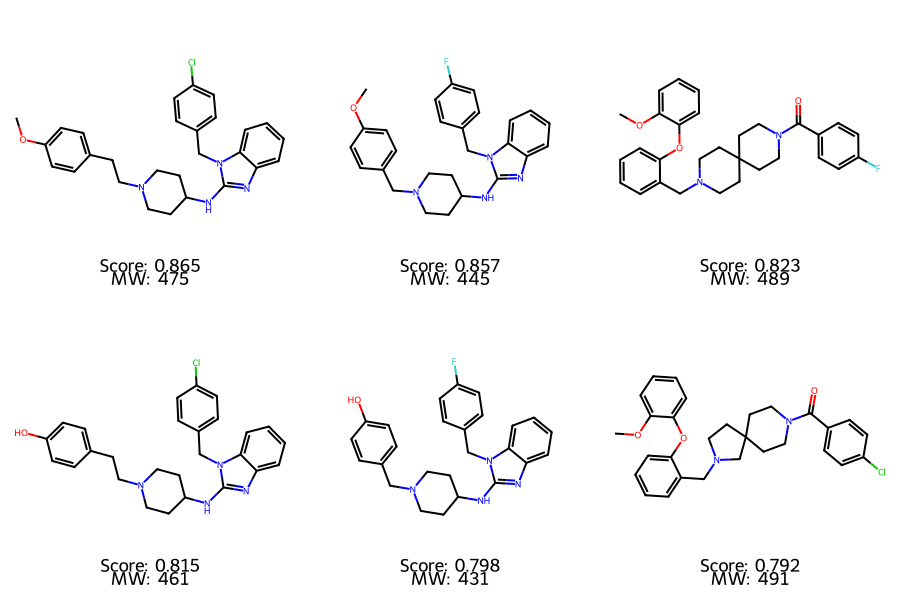

In [26]:
# Cell 13: Visualize top candidates
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image, display

# Get top 6 candidates
top_candidates = scored_variants[:6]
mols = [Chem.MolFromSmiles(c['smiles']) for c in top_candidates]
legends = [f"Score: {c['predicted_activity']:.3f}\nMW: {c['MW']:.0f}" for c in top_candidates]

def mol_grid_to_png(mols, legends, molsPerRow=3, subImgSize=(300,300)):
    nRows = (len(mols) + molsPerRow - 1) // molsPerRow
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])

    d2d = rdMolDraw2D.MolDraw2DCairo(fullSize[0], fullSize[1], subImgSize[0], subImgSize[1])
    d2d.drawOptions().legendFontSize = 18
    d2d.DrawMolecules(mols, legends=legends)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

png_data = mol_grid_to_png(mols, legends)

# Save to Drive
save_path = '/content/drive/MyDrive/GNN_antibiotics/novel_antibiotic_candidates.png'
with open(save_path, 'wb') as f:
    f.write(png_data)
print(f"Saved to: {save_path}")

# Display
display(Image(png_data))

```


┌─────────────────────────────────────────────────────────────────┐
│                    DATA FOUNDATION                               │
├─────────────────────────────────────────────────────────────────┤
│ ChEMBL GyrB IC50s                                               │
│     ↓                                                           │
│ Scaffold Split (Murcko) → Train / Val / Test                    │
│ (Report BOTH random and scaffold split metrics)                 │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│                    MODEL ENSEMBLE                                │
├─────────────────────────────────────────────────────────────────┤
│ 5x GAT Models (different seeds)                                 │
│     - 3 GAT layers + attention extraction                       │
│     - BatchNorm, Dropout                                        │
│     - Global attention pooling                                  │
│                                                                 │
│ Output: P(active) ± uncertainty                                 │
│         Atom-level attention weights                            │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│                    GENERATION + FILTERING                        │
├─────────────────────────────────────────────────────────────────┤
│ Molecular perturbation (improved)                               │
│     ↓                                                           │
│ Filter cascade:                                                 │
│   1. Chemical validity (valence, ring sanity)                   │
│   2. Drug-likeness (QED > 0.5, Lipinski)                       │
│   3. Synthetic accessibility (SAScore < 4)                      │
│   4. Novelty check (not in ChEMBL/PubChem)                     │
│   5. Ensemble prediction (P > 0.7, low uncertainty)            │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│                    MULTI-OBJECTIVE PROFILING                     │
├─────────────────────────────────────────────────────────────────┤
│ For top candidates:                                             │
│   - ADMET predictions (Tox21, hERG, CYP)                       │
│   - Selectivity: GyrB vs human TopoII                          │
│   - Docking: AutoDock Vina into GyrB structure                 │
│   - Attention visualization + SAR interpretation               │
│                                                                 │
│ Output: Pareto-ranked candidates with full profile             │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│                    MECHANISTIC VALIDATION                        │
├─────────────────────────────────────────────────────────────────┤
│ Compare GAT attention to:                                       │
│   - Known fluoroquinolone pharmacophore                        │
│   - Docking contact residues                                    │
│   - Published SAR from literature                               │
│                                                                 │
│ Converging evidence = rigorous science                         │
└─────────────────────────────────────────────────────────────────┘
```